In [1]:
#!pip install jupyterthemes
#!jt -t onedork -T -N -kl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data
## Read in files

In [3]:
# read in files
trips_df = pd.read_csv("Household_Travel_Survey_Trips.csv")
hh_df = pd.read_csv("Household_Travel_Survey_Households.csv")

# this dataset is from USDA and contains information on the food access/desert status of a census tract
# https://www.ers.usda.gov/data-products/food-access-research-atlas/
access_df = pd.read_csv("USDA_FoodAccess_Data.csv")

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_1498/2716080136.py:2: DtypeWarning: Columns (5,8,25,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,52,68,69,73,75,76,86,87,88,89,90,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,130,131,132,133,134,135,136,137,138,139,140,142,154) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_df = pd.read_csv("Household_Travel_Survey_Trips.csv")


In [4]:
# create weights col for trips data
trips_2017 = trips_df[trips_df["survey_year"]==2017]
trips_2017.loc[:,"weights"] = trips_2017.loc[:,"trip_weight_2017_v2021"]

trips_2019 = trips_df[trips_df["survey_year"]==2019]
trips_2019.loc[:,"weights"] = trips_2019.loc[:,"trip_weight_2019_v2021"]

trips_2021 = trips_df[trips_df["survey_year"]==2021]
# trips_2021.loc[:,"weights"] = trips_2021.loc[:,"trip_weight_2021_ABS_Panel_resp"]
trips_2021["weights"] = 1

trips_df = pd.concat([trips_2017, trips_2019, trips_2021])

print("number of entries before cleaning: " + str(len(trips_df)))

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_1498/2916153990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_2017.loc[:,"weights"] = trips_2017.loc[:,"trip_weight_2017_v2021"]
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_1498/2916153990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_2019.loc[:,"weights"] = trips_2019.loc[:,"trip_weight_2019_v2021"]
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_1498/2916153990.py:10: SettingWithCopyWarning: 
A val

number of entries before cleaning: 136079


## Clean Data

In [5]:
# clean up trip data-- only get rid of rows with NaNs (delete rows)
trips_df.replace([np.inf, -np.inf], np.nan, inplace=True)
trips_df.dropna(subset=["travel_time","trip_path_distance"], inplace=True)

# only include entries from King County
trips_df = trips_df[trips_df["sample_county"] == "King"]

In [6]:
# one hot encode
mode = pd.get_dummies(trips_df["mode_simple"])
race = pd.get_dummies(trips_df["hh_race_category"])
edu = pd.get_dummies(trips_df["education"])
empl = pd.get_dummies(trips_df["employment"])
empl.rename(columns = {"Employed full time (35+ hours/week, paid)": "Full time", 
             "Employed part time (fewer than 35 hours/week, paid)":"Part time",
                      "Not currently employed": "Unemployed"}, inplace= True)
gender = pd.get_dummies(trips_df["gender"])
rent = pd.get_dummies(trips_df["rent_own"])
rent.rename(columns = {"Own/paying mortgage": "Own"}, inplace = True)

trips_df = pd.concat([trips_df, mode, race, edu, empl, rent], axis = 1)
trips_df

rent

,Other,Own,Prefer not to answer,Provided by job or military,Rent
63200,0,0,0,0,1
63201,0,0,0,0,1
63202,0,0,0,0,1
63203,0,1,0,0,0
63204,0,1,0,0,0
...,...,...,...,...,...
136009,0,0,0,0,1
136010,0,0,0,0,1
136011,0,0,0,0,1
136012,0,0,0,0,1


In [7]:
# turn categorical into numerical data
def encode(input_df):
    # copy original df
    trips_df_encoded = input_df.copy()

    # encode ordinal data only:
    ordinal_cols = ["vehicle_count", "hhincome_broad", "hhincome_detailed", "hhsize", "age", "commute_freq"]
    for col in ordinal_cols:
        trips_df_encoded.loc[:, col] = trips_df_encoded[col].astype('category').cat.codes

#     one hot encode non-ordered nominal data: (encode it for now)
    nominal_cols = [ "gender", "dest_purpose", "origin_purpose"]
    for col in nominal_cols:
        trips_df_encoded.loc[:, col] = trips_df_encoded[col].astype('category').cat.codes
    
    return trips_df_encoded

In [8]:
# clean up USDA food access data-- only need info on King County for low income, low access, low vehicle access
# lila_df = access_df[(access_df["County"] == "King County") & (access_df["LILATracts_Vehicle"] == 1)]
lila_df = access_df[(access_df["County"] == "King County") & (access_df["LILATracts_halfAnd10"] == 1)]
lila_df = lila_df[["CensusTract", "State", "County", "LILATracts_halfAnd10"]]
lila_df.head()

,CensusTract,State,County,LILATracts_halfAnd10
69375,53033000100,Washington,King County,1
69376,53033000200,Washington,King County,1
69381,53033000600,Washington,King County,1
69387,53033001200,Washington,King County,1
69417,53033004301,Washington,King County,1


In [9]:
print("number of entries after cleaning: " + str(len(trips_df)))

number of entries after cleaning: 52312


# Analysis on mode choice, travel time
## For all tracts:

In [10]:
# filter for all grocery trips
grocery_trips = trips_df[(trips_df["origin_purpose"] == "Went grocery shopping") | (trips_df["dest_purpose"] == "Went grocery shopping")]
# join grocery trips with household df to have associated census tract 
grocery_trips = grocery_trips.merge(hh_df[["household_id", "final_home_tract10"]], on="household_id", how='left')

grocery_mode = grocery_trips.groupby("mode_simple").sum()[["weights"]]
grocery_mode.rename(columns={"weights":"trips"}, inplace=True)

grocery_mode["percentage"] = np.around(grocery_mode["trips"]/sum(grocery_mode["trips"])*100, 1)
grocery_mode["median time"] = grocery_trips.groupby("mode_simple").median()["travel_time"]

grocery_mode.sort_values(by=["trips"], inplace=True, ascending=False)

print("n = " + str(len(grocery_trips)))
grocery_mode

n = 5400


,trips,percentage,median time
mode_simple,,,
Drive,1.081274e+06,86.4,10.0
Walk,1.113937e+05,8.9,6.4
Transit,5.600368e+04,4.5,15.0
Other,2.015081e+03,0.2,11.5
Bike,9.812117e+02,0.1,15.0


## For LILA at 1/2 and 10 mi

In [11]:
# list of LILA census tracts
lila_tracts = list(lila_df["CensusTract"])

# # join grocery trips with household df to have associated census tract 
# grocery_hh_trips = grocery_trips.merge(hh_df[["household_id", "final_home_tract10"]], on="household_id", how='left')

# filter to only include LILA, low vehicle census tracts
grocery_lila = grocery_trips[grocery_trips["final_home_tract10"].isin(lila_tracts)]
print("n = " + str(len(grocery_lila)))

# manipulate df to get mode, travel time
lila_mode = grocery_lila.groupby("mode_simple").sum()[["weights"]]
lila_mode.rename(columns={"weights":"trips"}, inplace=True)
lila_mode["percentage"] = np.around(lila_mode["trips"]/sum(lila_mode["trips"])*100, 1)
lila_mode["median time"] = grocery_lila.groupby("mode_simple").median()["travel_time"]
lila_mode.sort_values(by="trips", ascending=False)


####### actually a higher percentage of people driving... potentially because they may be located in rural areas
###### and are forced to drive? most of the lila low vehicle areas are further out from the city/urban areas

n = 840


,trips,percentage,median time
mode_simple,,,
Drive,194222.788453,94.3,10.3
Walk,6543.044870,3.2,5.6
Transit,5213.866652,2.5,28.5
Bike,9.381531,0.0,30.0
Other,4.240317,0.0,2.7


## EDA: How long does it take people to travel to the store?

n = 5400


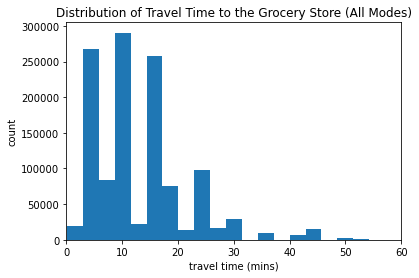

In [12]:
print("n = " + str(len(grocery_trips)))
plt.hist(grocery_trips["travel_time"], weights=grocery_trips["weights"], bins = 200)
plt.xlim([0, 60])
plt.xlabel("travel time (mins)")
plt.ylabel("count")
plt.title("Distribution of Travel Time to the Grocery Store (All Modes)")
plt.show()

n = 3375


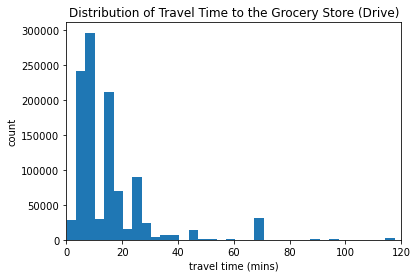

In [13]:
# drivers
grocery_time_clean = grocery_trips[grocery_trips["mode_simple"]=="Drive"]
print("n = " + str(len(grocery_time_clean)))
plt.hist(grocery_time_clean["travel_time"], weights=grocery_time_clean["weights"], bins = 125)
plt.xlim([0, 120])
plt.xlabel("travel time (mins)")
plt.ylabel("count")
plt.title("Distribution of Travel Time to the Grocery Store (Drive)")
plt.show()

n = 330


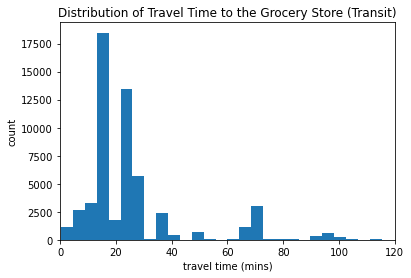

In [14]:
# transit travel times
grocery_time_clean = grocery_trips[grocery_trips["mode_simple"]=="Transit"]
print("n = " + str(len(grocery_time_clean)))
plt.hist(grocery_time_clean["travel_time"], weights=grocery_time_clean["weights"], bins = 100)
plt.xlim([0, 120])
plt.xlabel("travel time (mins)")
plt.ylabel("count")
plt.title("Distribution of Travel Time to the Grocery Store (Transit)")
plt.show()

n = 1543


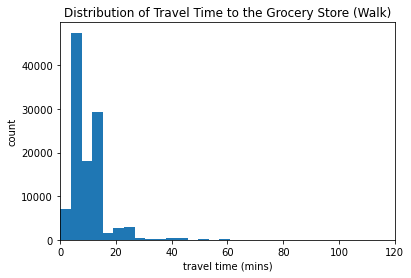

,household_id,person_dim_id,trip_id,hhid,survey_year,sample_source,seattle_home,hh_race_category,hhgroup,sample_county,...,Unemployed,Retired,Self-employed,Unpaid volunteer or intern,Other,Own,Prefer not to answer,Provided by job or military,Rent,final_home_tract10
5,191000092,19100009201,19100009201020,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033007500
6,191000092,19100009201,19100009201021,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033007500
7,191000092,19100009201,19100009201022,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033007500
11,191000262,19100026201,19100026201004,191000262,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033010300
12,191000262,19100026201,19100026201005,191000262,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033010300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5380,192016873,19201687303,19201687303003,192016873,2019,NaN,Home in Seattle,Asian,rSurvey,King,...,1,0,0,0,0,1,0,0,0,53033010500
5392,192017308,19201730801,19201730801004,192017308,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033010500
5393,192017308,19201730801,19201730801005,192017308,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033010500
5398,192018372,19201837201,19201837201004,192018372,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,1,0,0,0,0,0,1,53033002900


In [15]:
# travel time for those who walk
grocery_time_clean = grocery_trips[grocery_trips["mode_simple"]=="Walk"]
print("n = " + str(len(grocery_time_clean)))
plt.hist(grocery_time_clean["travel_time"], weights=grocery_time_clean["weights"],bins = 150)
plt.xlim([0, 120])
plt.xlabel("travel time (mins)")
plt.ylabel("count")
plt.title("Distribution of Travel Time to the Grocery Store (Walk)")
plt.show()

grocery_time_clean

# Linear regression models
## Model 1: All tracts, what are the factors impacting travel time to the store?

In [16]:
# turn categorical data into numerical
grocery_encoded = encode(grocery_trips)
grocery_encoded

,household_id,person_dim_id,trip_id,hhid,survey_year,sample_source,seattle_home,hh_race_category,hhgroup,sample_county,...,Unemployed,Retired,Self-employed,Unpaid volunteer or intern,Other,Own,Prefer not to answer,Provided by job or military,Rent,final_home_tract10
0,191000076,19100007602,19100007602001,191000076,2019,NaN,Home in Seattle,Asian,rSurvey,King,...,0,0,0,0,0,0,0,0,1,53033007500
1,191000076,19100007602,19100007602002,191000076,2019,NaN,Home in Seattle,Asian,rSurvey,King,...,0,0,0,0,0,0,0,0,1,53033007500
2,191000092,19100009201,19100009201006,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033007500
3,191000092,19100009201,19100009201007,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033007500
4,191000092,19100009201,19100009201008,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,1,53033007500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,192018040,19201804001,19201804001003,192018040,2019,NaN,Home in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,0,0,0,1,53033007500
5396,192017485,19201748501,19201748501002,192017485,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,1,0,0,0,53033003600
5397,192017485,19201748501,19201748501003,192017485,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,1,0,0,0,53033003600
5398,192018372,19201837201,19201837201004,192018372,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,1,0,0,0,0,0,1,53033002900


In [17]:
for col in grocery_encoded.columns:
    print(col)


household_id
person_dim_id
trip_id
hhid
survey_year
sample_source
seattle_home
hh_race_category
hhgroup
sample_county
final_home_puma10
final_home_uvnum
hhsize
vehicle_count
lifecycle
hhincome_broad
hhincome_detailed
car_share
rent_own
res_dur
res_type
prev_home_wa
res_factors_30min
res_factors_afford
res_factors_closefam
res_factors_hhchange
res_factors_hwy
res_factors_school
res_factors_space
res_factors_transit
res_factors_walk
prev_res_factors_housing_cost
prev_res_factors_income_change
prev_res_factors_community_chan
prev_res_factors_hh_size
prev_res_factors_more_space
prev_res_factors_less_space
prev_res_factors_employment
prev_res_factors_school
prev_res_factors_crime
prev_res_factors_quality
prev_res_factors_forced
prev_res_factors_no_answer
prev_res_factors_other
prev_res_factors_specify
prev_res_factors_covid_flexibil
prev_res_factors_covid_health
broadband
numadults
numchildren
numworkers
offpark_cost
cityofseattle
age
age_category
gender
employment
jobs_count
student
school

In [18]:
# split into target attributes and potential factors
target_df = grocery_encoded[["travel_time"]]
predictors_df = grocery_encoded.drop(["travel_time"], axis=1, inplace=False)


In [19]:
# intial attempt

# use linear regression, guess and check
X = predictors_df[["trip_path_distance", "numadults", "speed_mph", "African American", "Asian", "Hispanic", "White Only",
                  "commute_freq", "hhincome_broad", "hhsize", "age",  "origin_purpose",
                  "dest_purpose", "daynum", "travelers_total", "Bike", "Drive", "Transit", "Walk", "vehicle_count", 
                   "High school graduate", "Bachelor degree", "Graduate/post-graduate degree", 
                  "Associates degree", "Less than high school", "Full time", "Part time", "Self-employed",
                   "Homemaker", "Unemployed", "Retired", "gender", "Rent", "Own"]]
y = target_df["travel_time"]
# X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            travel_time   R-squared (uncentered):                   0.482
Model:                            OLS   Adj. R-squared (uncentered):              0.479
Method:                 Least Squares   F-statistic:                              147.0
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:04:57   Log-Likelihood:                         -23091.
No. Observations:                5400   AIC:                                  4.625e+04
Df Residuals:                    5366   BIC:                                  4.647e+04
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
trip_path_distance                1.3390      0.038     35.205      0.000       1.264       1.414
numadults                         0.0850      0.672      0.127      0.899      -1.231       1.401
speed_mph                        -0.2837      0.033     -8.577      0.000      -0.349      -0.219
African American                  2.5303      1.648      1.536      0.125      -0.700       5.760
Asian                            -1.0987      0.921     -1.193      0.233      -2.904       0.706
Hispanic                         -0.9311      1.262     -0.738      0.461      -3.405       1.542
White Only                       -1.5908      0.807     -1.971      0.049      -3.173      -0.008
commute_freq                      0.1619      0.168      0.962      0.336      -0.168       0.492
hhincome_broad                   -0.1241      0.167     -0.743      0.458      -0.452       0.204
hhsize                           -0.2860      0.427     -0.670      0.503      -1.123       0.551
age                               0.5940      0.146      4.079      0.000       0.309       0.879
origin_purpose                    0.1246      0.065      1.920      0.055      -0.003       0.252
dest_purpose                      0.1167      0.094      1.242      0.214      -0.068       0.301
daynum                           -0.6224      0.113     -5.497      0.000      -0.844      -0.400
travelers_total                   0.0004      0.000      1.241      0.215      -0.000       0.001
Bike                             11.0815      3.566      3.108      0.002       4.091      18.072
Drive                             2.8260      1.519      1.860      0.063      -0.152       5.804
Transit                          10.8889      1.737      6.269      0.000       7.484      14.294
Walk                              0.9770      1.505      0.649      0.516      -1.974       3.928
vehicle_count                     0.3105      0.392      0.792      0.428      -0.458       1.079
High school graduate              0.1486      1.503      0.099      0.921      -2.798       3.096
Bachelor degree                  -0.7688      0.908     -0.846      0.397      -2.550       1.012
Graduate/post-graduate degree    -0.6353      0.928     -0.684      0.494      -2.455       1.184
Associates degree                -0.9592      1.385     -0.693      0.488      -3.673       1.755
Less than high school            11.6667      3.826      3.049      0.002       4.166      19.167
Full time                         4.2443      1.428      2.973      0.003       1.445       7.043
Part time                         5.7724      1.637      3.525      0.000       2.562       8.982
Self-employed                     3.0797    

In [20]:
# collinearity check
corr = np.corrcoef(X, rowvar=0)
w, v = np.linalg.eig(corr)
print(w)
print("since the first variable is close to zero, it must have collinearity with some other variable. check.")
print()
print(v[:,0])
print("the first and third variables are collinear (distance and speed). only use one of these in the regression.")

[3.82649207 2.77905304 2.06177799 1.89673271 1.60768027 0.040081
 0.04402381 0.0489737  0.15554156 0.17954989 0.21447681 0.29236326
 0.33671782 1.47371241 0.42966959 0.57414133 0.62823865 1.32992915
 1.20654308 0.80911844 1.16419866 1.14357218 0.84345175 1.10646819
 1.08120503 1.0524397  1.04507475 1.00586124 0.99769175 0.96657011
 0.88617429 0.94523265 0.92084705 0.90639607]
since the first variable is close to zero, it must have collinearity with some other variable. check.

[-0.13387966 -0.2801645  -0.24311475  0.06826295 -0.05231738  0.01509023
  0.01764236 -0.0754122   0.18762298 -0.3275672  -0.16576679  0.01342535
  0.04000226 -0.00529371 -0.00647292  0.01648626 -0.36729151  0.13210293
  0.30509981 -0.37554952  0.06042048  0.06658494 -0.03264404 -0.00107043
 -0.00241498  0.09284997 -0.0073037  -0.01354026 -0.06637693  0.05737559
 -0.03235195  0.01884635  0.35345405 -0.34674392]
the first and third variables are collinear (distance and speed). only use one of these in the regressi

In [21]:
# another collinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set is X
X_test = X

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

                          feature        VIF
0              trip_path_distance   1.789651
1                       numadults  26.562502
2                       speed_mph   4.257244
3                African American   1.317067
4                           Asian   2.982368
5                        Hispanic   1.581197
6                      White Only   7.124009
7                    commute_freq  15.844054
8                  hhincome_broad   2.254736
9                          hhsize   6.773869
10                            age  10.265777
11                 origin_purpose   9.447403
12                   dest_purpose  14.682264
13                         daynum   4.232512
14                travelers_total   1.014254
15                           Bike   1.208626
16                          Drive  25.532351
17                        Transit   3.264154
18                           Walk  11.457903
19                  vehicle_count   5.631606
20           High school graduate   1.511250
21        

In [22]:
# second attempt-- account for collinearity (remove either distance or speed). and remove p-values > 0.05
# use linear regression, guess and check
X = predictors_df[["trip_path_distance",  "speed_mph", 
                    "daynum", "African American",  "Less than high school",
                   "Rent", "age","Bike", "Drive", "Transit", "Walk",]]
y = target_df["travel_time"]
# X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            travel_time   R-squared (uncentered):                   0.476
Model:                            OLS   Adj. R-squared (uncentered):              0.475
Method:                 Least Squares   F-statistic:                              445.7
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:04:57   Log-Likelihood:                         -23121.
No. Observations:                5400   AIC:                                  4.626e+04
Df Residuals:                    5389   BIC:                                  4.634e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
trip_path_distance        1.3288      0.038     34.967      0.000       1.254       1.403
speed_mph                -0.2564      0.033     -7.814      0.000      -0.321      -0.192
daynum                   -0.5167      0.109     -4.750      0.000      -0.730      -0.303
African American          3.8066      1.482      2.569      0.010       0.902       6.711
Less than high school    12.7294      3.756      3.389      0.001       5.366      20.092
Rent                      2.2346      0.502      4.449      0.000       1.250       3.219
age                       0.4629      0.106      4.365      0.000       0.255       0.671
Bike                     19.2885      3.334      5.785      0.000      12.752      25.825
Drive                    10.8188      0.862     12.554      0.000       9.129      12.508
Transit                  18.7034      1.251     14.945      0.000      16.250      21.157
Walk                      9.0345      0.856     10.553      0.000       7.356      10.713
==============================================================================
Omnibus:                    10401.975   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28529193.769
Skew:                          14.843   Prob(JB):                         0.00
Kurtosis:                     357.845   Cond. No.                         261.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# another collinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set is X
X_test = X
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

                  feature       VIF
0      trip_path_distance  1.774212
1               speed_mph  4.161644
2                  daynum  3.879336
3        African American  1.057714
4   Less than high school  1.010293
5                    Rent  2.278007
6                     age  5.405566
7                    Bike  1.049422
8                   Drive  8.160190
9                 Transit  1.682512
10                   Walk  3.681520


In [24]:
# collinearity check
corr = np.corrcoef(X, rowvar=0)
w, v = np.linalg.eig(corr)
print(w)
print("since the first variable is close to zero, it must have collinearity with some other variable. check.")
print()
print(v[:,4])
print("the first and third variables are collinear (distance and speed). only use one of these in the regression.")

[2.53561208 0.04384709 0.33979155 1.41250545 0.63199348 1.23241621
 0.83826157 0.90054709 1.04588429 1.00071319 1.018428  ]
since the first variable is close to zero, it must have collinearity with some other variable. check.

[-0.03830891  0.01608205  0.14307197 -0.16364427  0.0253441   0.72322245
  0.63148822 -0.02837236  0.09721226 -0.13040249 -0.03597666]
the first and third variables are collinear (distance and speed). only use one of these in the regression.


In [25]:
### logistic regression attempt
# X = predictors_df[["trip_path_distance", "numadults","hh_race_category",
#                   "commute_freq",  "origin_purpose",
#                   "dest_purpose", "daynum"]]
# y = target_df["travel_time"]
# y_test = (y-y.min())/(y.max()-y.min())
# y_test
  
# # building the model and fitting the data
# log_reg = sm.Logit(y_test, X).fit()

# print(log_reg.summary())

Things to note:
* biking was heavily correlated with gender

## Model 1a: LILA tracts, what are the factors impacting travel time to the store?

### Run the model!

In [26]:
# turn categorical data into numerical
grocery_lila_encoded = encode(grocery_lila)
grocery_lila_encoded

# split into target attributes and potential factors
target1a_df = grocery_lila_encoded[["travel_time"]]
predictors1a_df = grocery_lila_encoded.drop(["travel_time"], axis=1, inplace=False)


In [27]:
# first attempt
# use linear regression, guess and check
X1a = predictors1a_df[["trip_path_distance", "numadults", "speed_mph", "African American", "Asian", "Hispanic", 
                       "White Only","commute_freq", "hhincome_broad", "hhsize", "age", "origin_purpose",
                  "dest_purpose", "daynum", "travelers_total", "Bike", "Drive", "Transit", "Walk", "vehicle_count", 
                     "High school graduate", "Bachelor degree", "Graduate/post-graduate degree", 
                  "Associates degree", "Less than high school", "Full time", "Part time", "Self-employed",
                   "Homemaker", "Unemployed", "Retired", "gender", "Rent", "Own"]]
y1a = target1a_df["travel_time"]
# X1a = sm.add_constant(X1a)

model1a = sm.OLS(y1a, X1a).fit()
predictions1a = model1a.predict(X1a) # make the predictions by the model

# Print out the statistics
model1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            travel_time   R-squared (uncentered):                   0.613
Model:                            OLS   Adj. R-squared (uncentered):              0.596
Method:                 Least Squares   F-statistic:                              37.51
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                   1.23e-141
Time:                        09:04:57   Log-Likelihood:                         -3527.6
No. Observations:                 840   AIC:                                      7123.
Df Residuals:                     806   BIC:                                      7284.
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
trip_path_distance                1.6837      0.093     18.102      0.000       1.501       1.866
numadults                         0.9036      1.752      0.516      0.606      -2.535       4.343
speed_mph                        -0.3900      0.080     -4.891      0.000      -0.546      -0.233
African American                  9.9934      3.235      3.089      0.002       3.643      16.344
Asian                             0.0277      2.672      0.010      0.992      -5.216       5.272
Hispanic                         -1.1713      2.782     -0.421      0.674      -6.632       4.289
White Only                        0.3576      2.212      0.162      0.872      -3.984       4.700
commute_freq                     -0.0183      0.501     -0.037      0.971      -1.002       0.965
hhincome_broad                   -0.2775      0.409     -0.678      0.498      -1.081       0.526
hhsize                           -0.9190      1.040     -0.883      0.377      -2.961       1.123
age                               0.3151      0.444      0.709      0.478      -0.557       1.187
origin_purpose                    0.2905      0.175      1.664      0.097      -0.052       0.633
dest_purpose                      0.1587      0.252      0.629      0.529      -0.336       0.654
daynum                           -0.9167      0.290     -3.161      0.002      -1.486      -0.347
travelers_total                   0.0002      0.001      0.342      0.732      -0.001       0.001
Bike                             13.8363     17.288      0.800      0.424     -20.099      47.771
Drive                             1.3990      4.706      0.297      0.766      -7.839      10.637
Transit                          30.0819      5.299      5.676      0.000      19.680      40.484
Walk                             -2.7255      4.725     -0.577      0.564     -12.000       6.549
vehicle_count                     0.9701      1.058      0.917      0.359      -1.106       3.047
High school graduate              7.3129      2.749      2.660      0.008       1.917      12.709
Bachelor degree                   1.9514      2.059      0.948      0.344      -2.091       5.994
Graduate/post-graduate degree     1.5438      2.033      0.759      0.448      -2.447       5.535
Associates degree                 2.1736      2.832      0.768      0.443      -3.385       7.732
Less than high school            13.5486      5.514      2.457      0.014       2.724      24.373
Full time                        -0.2063      3.875     -0.053      0.958      -7.812       7.399
Part time                         3.2589      4.122      0.791      0.429      -4.832      11.349
Self-employed                    -1.7803    

In [28]:
# the independent variables set is X
X_test = X1a
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

                          feature        VIF
0              trip_path_distance   1.788763
1                       numadults  34.440296
2                       speed_mph   5.000164
3                African American   2.123043
4                           Asian   3.027253
5                        Hispanic   2.511733
6                      White Only   9.240484
7                    commute_freq  18.460444
8                  hhincome_broad   2.739311
9                          hhsize   7.442057
10                            age   9.659913
11                 origin_purpose   9.990648
12                   dest_purpose  15.355044
13                         daynum   4.996521
14                travelers_total   1.090415
15                           Bike   1.102361
16                          Drive  50.564593
17                        Transit   3.832576
18                           Walk  14.244103
19                  vehicle_count   8.230663
20           High school graduate   1.922897
21        

In [29]:
# second attempt-- remove variables with p > 0.05 and high t-statistic (above +/- 2)
# use linear regression, guess and check
X1a = predictors1a_df[["trip_path_distance",  "speed_mph",  "daynum", "African American",   
                       "High school graduate", "Less than high school", "Rent","Drive", "Transit",]]
y1a = target1a_df["travel_time"]
# X1a = sm.add_constant(X1a)

model1a = sm.OLS(y1a, X1a).fit()
predictions1a = model1a.predict(X1a) # make the predictions by the model

# Print out the statistics
model1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            travel_time   R-squared (uncentered):                   0.580
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              127.5
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                   5.12e-150
Time:                        09:04:57   Log-Likelihood:                         -3561.6
No. Observations:                 840   AIC:                                      7141.
Df Residuals:                     831   BIC:                                      7184.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
trip_path_distance        1.6607      0.094     17.650      0.000       1.476       1.845
speed_mph                -0.3370      0.080     -4.239      0.000      -0.493      -0.181
daynum                    0.1066      0.228      0.468      0.640      -0.341       0.554
African American          7.4776      2.454      3.047      0.002       2.661      12.295
High school graduate      6.5197      2.177      2.995      0.003       2.247      10.792
Less than high school    16.0657      5.359      2.998      0.003       5.546      26.585
Rent                      2.2353      1.235      1.810      0.071      -0.189       4.660
Drive                     9.8714      1.398      7.059      0.000       7.127      12.616
Transit                  38.7682      3.035     12.775      0.000      32.812      44.725
==============================================================================
Omnibus:                     1373.094   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1105370.668
Skew:                           9.785   Prob(JB):                         0.00
Kurtosis:                     179.633   Cond. No.                         160.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# the independent variables set is X
X_test = X1a
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

                 feature       VIF
0     trip_path_distance  1.740573
1              speed_mph  4.728551
2                 daynum  2.934921
3       African American  1.161680
4   High school graduate  1.146447
5  Less than high school  1.108069
6                   Rent  1.760471
7                  Drive  4.245337
8                Transit  1.195003


In [31]:
# collinearity check
corr = np.corrcoef(X1a, rowvar=0)
w, v = np.linalg.eig(corr)
print(w)
print("since the first variable is close to zero, it must have collinearity with some other variable. check.")
print()
print(v[:,0])
print("the first and third variables are collinear (distance and speed). only use one of these in the regression.")

[1.97998808 1.43652864 0.35044127 1.26286612 1.07313308 0.5657637
 0.89049189 0.65126144 0.78952579]
since the first variable is close to zero, it must have collinearity with some other variable. check.

[-0.4035389  -0.55807344 -0.18395635 -0.02777584  0.03914719  0.22403385
  0.22641704 -0.53160721  0.32481438]
the first and third variables are collinear (distance and speed). only use one of these in the regression.


# Model 1b: For non-LILA tracts, what are the factors impacting travel time?

In [32]:
# from grocery_encoded, remove grocery_lila_encoded
grocery_nonlila = grocery_encoded[~grocery_encoded["final_home_tract10"].isin(lila_tracts)]
print("n = " + str(len(grocery_nonlila)))

n = 4560


In [33]:
# split into target attributes and potential factors
target1b_df = grocery_nonlila[["travel_time"]]
predictors1b_df = grocery_nonlila.drop(["travel_time"], axis=1, inplace=False)

In [34]:
# first attempt
# use linear regression, guess and check
X1b = predictors1b_df[["trip_path_distance", "speed_mph", "daynum", 
                   "Full time", "Part time",
                   "Retired","Rent", "Bike", "Drive", "Transit", "Walk"]]
y1b = target1b_df["travel_time"]
# X1a = sm.add_constant(X1a)

model1b = sm.OLS(y1b, X1b).fit()
predictions1b = model1b.predict(X1b) # make the predictions by the model

# Print out the statistics
model1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            travel_time   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.459
Method:                 Least Squares   F-statistic:                              352.1
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:04:57   Log-Likelihood:                         -19532.
No. Observations:                4560   AIC:                                  3.909e+04
Df Residuals:                    4549   BIC:                                  3.916e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
trip_path_distance     1.2562      0.041     30.352      0.000       1.175       1.337
speed_mph             -0.2291      0.036     -6.379      0.000      -0.299      -0.159
daynum                -0.4648      0.120     -3.880      0.000      -0.700      -0.230
Full time              1.4707      0.633      2.323      0.020       0.229       2.712
Part time              2.5775      1.073      2.402      0.016       0.474       4.681
Retired                1.9525      0.915      2.135      0.033       0.159       3.746
Rent                   1.8123      0.540      3.355      0.001       0.753       2.871
Bike                  20.4079      3.367      6.060      0.000      13.806      27.010
Drive                 11.7501      0.802     14.647      0.000      10.177      13.323
Transit               17.4335      1.246     13.991      0.000      14.991      19.876
Walk                  10.0935      0.834     12.098      0.000       8.458      11.729
==============================================================================
Omnibus:                     8939.607   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         27107099.491
Skew:                          15.365   Prob(JB):                         0.00
Kurtosis:                     379.463   Cond. No.                         208.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# the independent variables set is X
X_test = X1b
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

               feature       VIF
0   trip_path_distance  1.784979
1            speed_mph  4.072582
2               daynum  3.936892
3            Full time  3.374244
4            Part time  1.313903
5              Retired  1.530216
6                 Rent  2.314004
7                 Bike  1.029671
8                Drive  5.751994
9              Transit  1.475222
10                Walk  3.092420


In [36]:
# collinearity check
corr = np.corrcoef(X1b, rowvar=0)
w, v = np.linalg.eig(corr)
print(w)
print("if a variable is close to zero, it must have collinearity with some other variable. check.")
print()
print(v[:,0])
print("the first and third variables are collinear (distance and speed). only use one of these in the regression.")

[2.50476578 0.04637822 1.6423002  0.33357328 0.39718438 0.75598239
 0.85968834 1.2298536  1.16590652 1.0247108  1.03965648]
if a variable is close to zero, it must have collinearity with some other variable. check.

[ 0.33943562  0.49710328  0.04762294 -0.02588062  0.02030143 -0.01856416
 -0.22658154 -0.03929947  0.55054707 -0.09773207 -0.51811194]
the first and third variables are collinear (distance and speed). only use one of these in the regression.


# Model 4: Combine all info into one model

In [37]:
# add indicator variable to determine if a tract is LILA or not
# check for collinearity, remove collinear variables
# check bivariate relationships, confirm that these relationships are present
# run linear regression model?

In [50]:
# add indicator variable
# all tracts, encoded
grocery_encoded = encode(grocery_trips)
grocery_encoded['LILA'] = np.where(grocery_encoded['final_home_tract10'].isin(lila_df["CensusTract"]), 1, 0)
grocery_encoded[["gender"]]

,gender
0,2
1,2
2,1
3,1
4,1
...,...
5395,1
5396,3
5397,3
5398,1


In [55]:
grocery_trips[["Bike"]].sum()

Bike    29
dtype: int64

In [39]:
target_df = grocery_encoded[["travel_time"]]
predictors_df = grocery_encoded.drop(["travel_time"], axis=1, inplace=False)

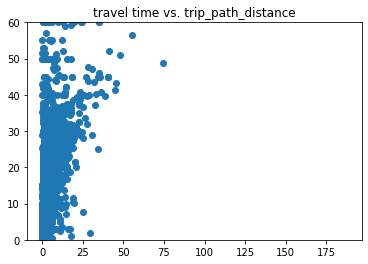

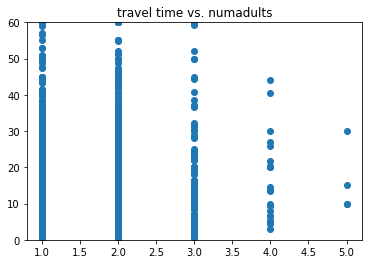

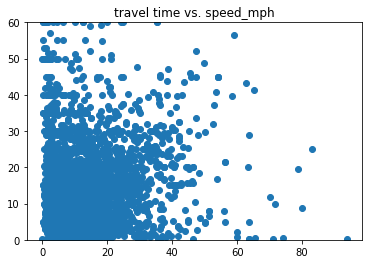

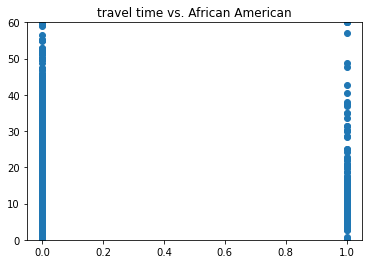

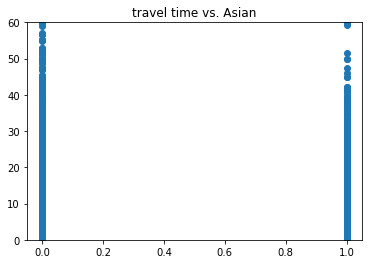

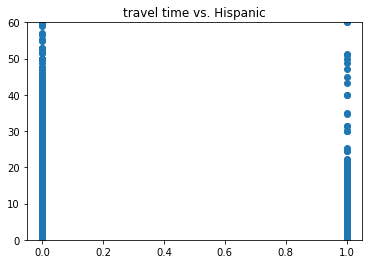

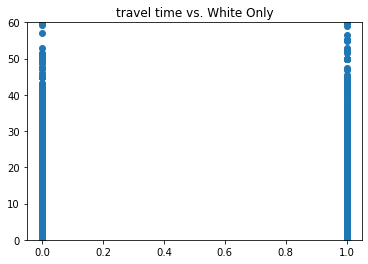

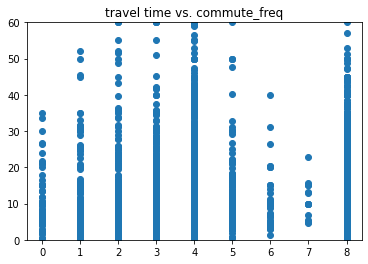

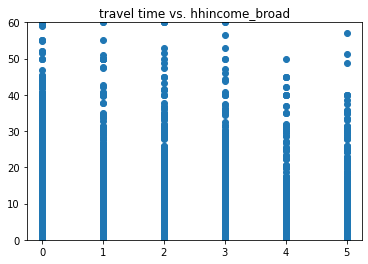

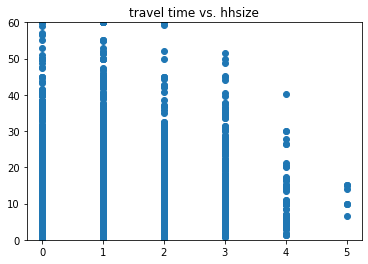

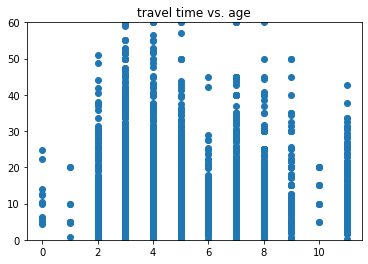

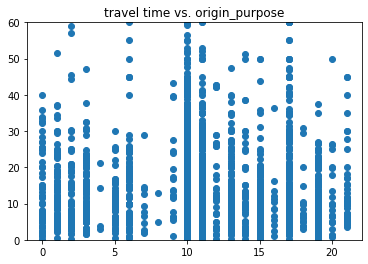

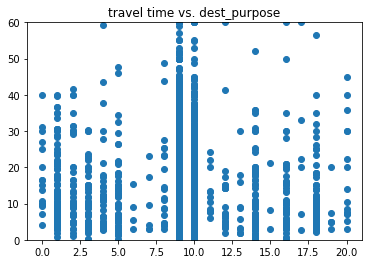

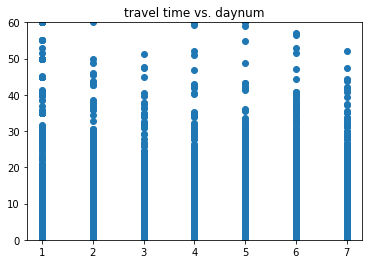

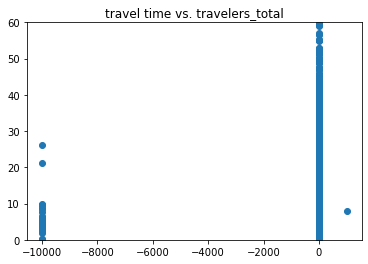

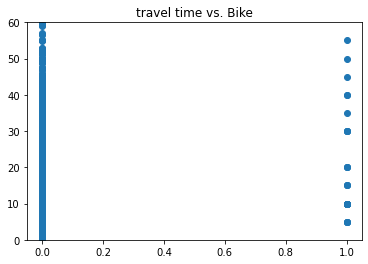

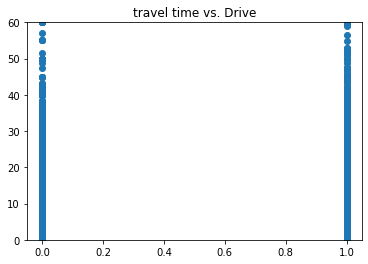

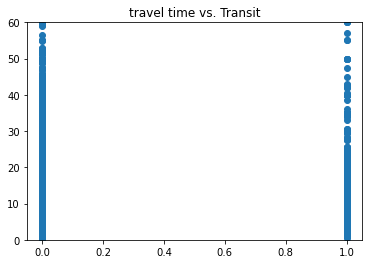

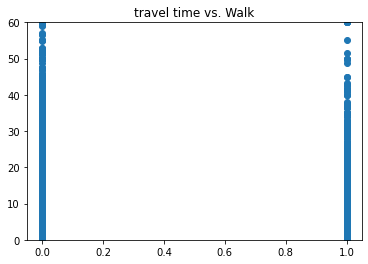

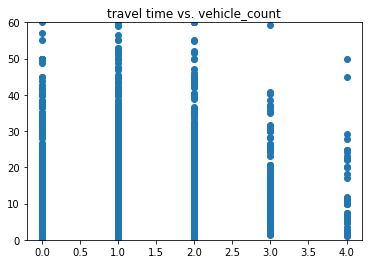

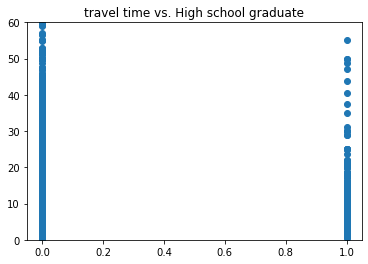

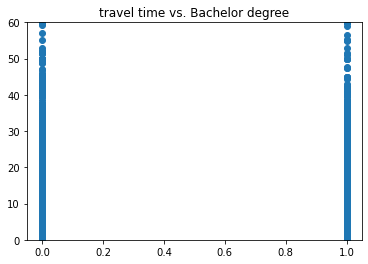

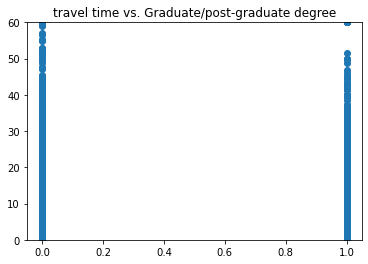

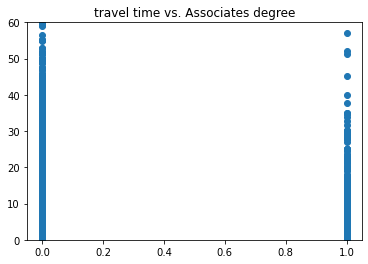

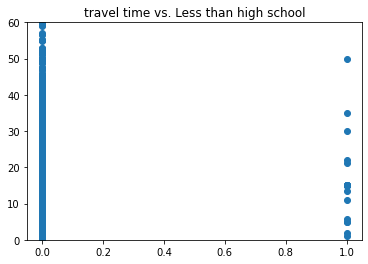

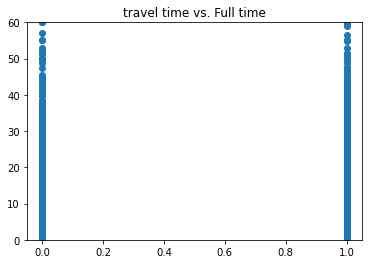

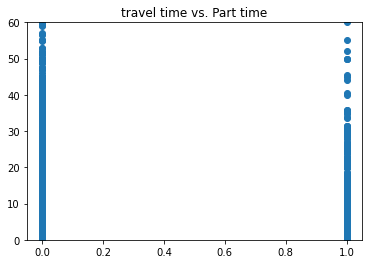

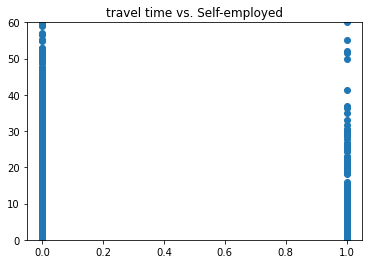

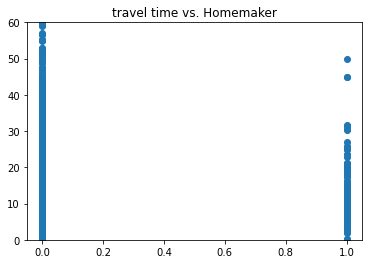

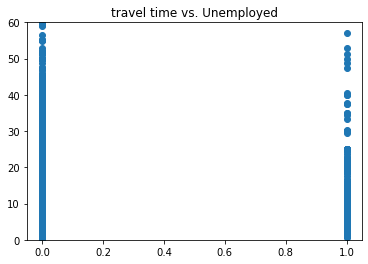

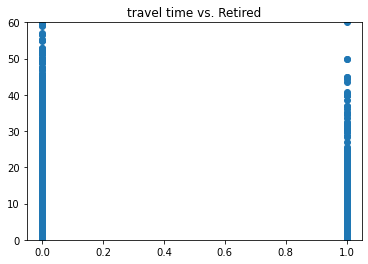

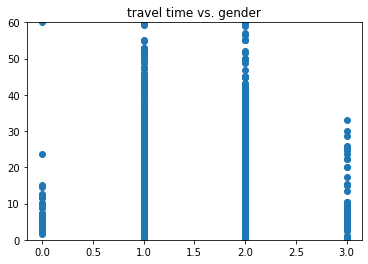

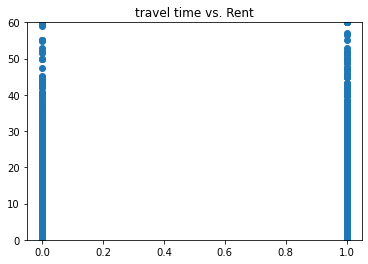

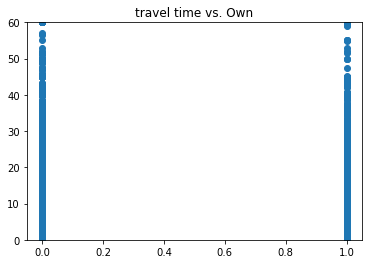

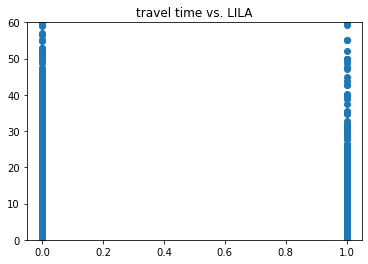

In [40]:
# plot col names vs. travel time
col_names = ["trip_path_distance", "numadults", "speed_mph", "African American", "Asian", "Hispanic", 
                       "White Only","commute_freq", "hhincome_broad", "hhsize", "age", "origin_purpose",
                  "dest_purpose", "daynum", "travelers_total", "Bike", "Drive", "Transit", "Walk", "vehicle_count", 
                     "High school graduate", "Bachelor degree", "Graduate/post-graduate degree", 
                  "Associates degree", "Less than high school", "Full time", "Part time", "Self-employed",
                   "Homemaker", "Unemployed", "Retired", "gender", "Rent", "Own", "LILA"]

for ea_col in col_names:
    plt.scatter(grocery_encoded[ea_col], grocery_encoded["travel_time"])
    plt.ylim([0, 60])
    plt.title("travel time vs. " + ea_col)
    plt.show()
    

In [41]:
# run bivariate regression
y = target_df["travel_time"]
for each_col in col_names:
    X = predictors_df[[each_col]]
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model

    # Print out the statistics
    print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            travel_time   R-squared (uncentered):                   0.301
Model:                            OLS   Adj. R-squared (uncentered):              0.301
Method:                 Least Squares   F-statistic:                              2323.
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:05:00   Log-Likelihood:                         -23902.
No. Observations:                5400   AIC:                                  4.781e+04
Df Residuals:                    5399   BIC:                                  4.781e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

NOT significant in bivariate: travelers_total

In [42]:
# remove travelers_total, check VIF/collinearity check

# redefine X without travelers_total
X = predictors_df[["trip_path_distance", "numadults", "speed_mph", "African American", "Asian", "Hispanic", 
                       "White Only","commute_freq", "hhincome_broad", "hhsize", "age", "origin_purpose",
                  "dest_purpose", "daynum", "Bike", "Drive", "Transit", "Walk", "vehicle_count", 
                     "High school graduate", "Bachelor degree", "Graduate/post-graduate degree", 
                  "Associates degree", "Less than high school", "Full time", "Part time", "Self-employed",
                   "Homemaker", "Unemployed", "Retired", "gender", "Rent", "Own", "LILA"]]

# the independent variables set is X
X_test = X

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

                          feature        VIF
0              trip_path_distance   1.789664
1                       numadults  26.669965
2                       speed_mph   4.263427
3                African American   1.335892
4                           Asian   2.981366
5                        Hispanic   1.593909
6                      White Only   7.132583
7                    commute_freq  15.873940
8                  hhincome_broad   2.273736
9                          hhsize   6.812167
10                            age  10.285126
11                 origin_purpose   9.447199
12                   dest_purpose  14.676626
13                         daynum   4.229918
14                           Bike   1.208638
15                          Drive  25.573138
16                        Transit   3.265340
17                           Walk  11.466535
18                  vehicle_count   5.642049
19           High school graduate   1.515780
20                Bachelor degree   6.036306
21  Gradua

In [43]:
# vif comparisons
# remove origin purpose, destination purpose
X = predictors_df[["trip_path_distance", "speed_mph", 
                   "African American", "Asian", "Hispanic", "White Only",
                   "hhincome_broad", "hhsize", 
                   "daynum", "Bike", "Drive", "Transit", "Walk", 
                     "High school graduate", "Bachelor degree", "Graduate/post-graduate degree", 
                  "Associates degree", "Less than high school", "Full time", "Part time", "Self-employed",
                   "Homemaker", "Unemployed", "Retired", "gender", "Rent", "LILA"]]

# the independent variables set is X
X_test = X

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i)
                          for i in range(len(X_test.columns))]
  
print(vif_data)

matrix = X.corr()
print("Correlation matrix is : ")
print(matrix)

                          feature        VIF
0              trip_path_distance   1.782679
1                       speed_mph   4.243044
2                African American   1.308020
3                           Asian   2.826029
4                        Hispanic   1.530190
5                      White Only   6.443195
6                  hhincome_broad   2.109831
7                          hhsize   3.127485
8                          daynum   4.170195
9                            Bike   1.120796
10                          Drive  15.389120
11                        Transit   2.335464
12                           Walk   7.300478
13           High school graduate   1.496639
14                Bachelor degree   5.933721
15  Graduate/post-graduate degree   5.345232
16              Associates degree   1.562588
17          Less than high school   1.055300
18                      Full time  14.136478
19                      Part time   2.624316
20                  Self-employed   2.328538
21        

Note: I want to keep driving and walking bc those are important modes! even though they are correlated. Also keeping full time and gender bc correlation matrix doesn't show the are correlated with other variables, even though the VIF is high.

In [44]:
y = target_df["travel_time"]
X = predictors_df[["trip_path_distance", "speed_mph", 
                   "African American", "Asian", "Hispanic", "White Only",
                   "hhincome_broad", "hhsize", 
                   "daynum", "Bike", "Drive", "Transit", "Walk", 
                     "High school graduate", "Bachelor degree", "Graduate/post-graduate degree", 
                  "Associates degree", "Less than high school", "Full time", "Part time", "Self-employed",
                   "Homemaker", "Unemployed", "Retired", "gender", "Rent", "LILA"]]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            travel_time   R-squared (uncentered):                   0.477
Model:                            OLS   Adj. R-squared (uncentered):              0.475
Method:                 Least Squares   F-statistic:                              181.7
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:05:00   Log-Likelihood:                         -23116.
No. Observations:                5400   AIC:                                  4.629e+04
Df Residuals:                    5373   BIC:                                  4.646e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [45]:
# iteration 2 to remove non-significant variables
y = target_df["travel_time"]
X = predictors_df[["trip_path_distance", "speed_mph", 
                   "African American", 
                   "daynum", "Bike", "Drive", "Transit", "Walk", 
                     "Less than high school", "Full time", "Part time", 
                   "Retired", "gender", "Rent", "LILA"]]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            travel_time   R-squared (uncentered):                   0.477
Model:                            OLS   Adj. R-squared (uncentered):              0.475
Method:                 Least Squares   F-statistic:                              326.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:05:00   Log-Likelihood:                         -23120.
No. Observations:                5400   AIC:                                  4.627e+04
Df Residuals:                    5385   BIC:                                  4.637e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

add interaction terms

In [46]:
significant_vars = ["trip_path_distance", "speed_mph", 
                   "African American", 
                   "daynum", "Bike", "Drive", "Transit", "Walk", 
                     "Less than high school", "Full time", "Part time", 
                   "Retired", "gender", "Rent", "LILA"]

# create interaction variables: [name of var ] * [LILA]
for i in range(len(significant_vars)-1):
    grocery_encoded[significant_vars[i] + "_LILA"] = grocery_encoded["LILA"] * grocery_encoded[significant_vars[i]]

grocery_encoded
    

,household_id,person_dim_id,trip_id,hhid,survey_year,sample_source,seattle_home,hh_race_category,hhgroup,sample_county,...,Bike_LILA,Drive_LILA,Transit_LILA,Walk_LILA,Less than high school_LILA,Full time_LILA,Part time_LILA,Retired_LILA,gender_LILA,Rent_LILA
0,191000076,19100007602,19100007602001,191000076,2019,NaN,Home in Seattle,Asian,rSurvey,King,...,0,0,0,0,0,0,0,0,0,0
1,191000076,19100007602,19100007602002,191000076,2019,NaN,Home in Seattle,Asian,rSurvey,King,...,0,0,0,0,0,0,0,0,0,0
2,191000092,19100009201,19100009201006,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,0,0
3,191000092,19100009201,19100009201007,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,0,0
4,191000092,19100009201,19100009201008,191000092,2019,NaN,Home in Seattle,White Only,rMove,King,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,192018040,19201804001,19201804001003,192018040,2019,NaN,Home in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,0,0,0,0,0
5396,192017485,19201748501,19201748501002,192017485,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,0,0,0,0,0
5397,192017485,19201748501,19201748501003,192017485,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,0,0,0,0,0
5398,192018372,19201837201,19201837201004,192018372,2019,NaN,Home not in Seattle,White Only,rSurvey,King,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# iteration 3: rerun model with interaction variables
target_df = grocery_encoded[["travel_time"]]
predictors_df = grocery_encoded.drop(["travel_time"], axis=1, inplace=False)

for i in range(len(significant_vars)-1):
    significant_vars.append(significant_vars[i]+"_LILA")
significant_vars

y = target_df["travel_time"]
X = predictors_df[significant_vars]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())
print(significant_vars)

                                 OLS Regression Results                                
Dep. Variable:            travel_time   R-squared (uncentered):                   0.487
Model:                            OLS   Adj. R-squared (uncentered):              0.484
Method:                 Least Squares   F-statistic:                              175.5
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:05:00   Log-Likelihood:                         -23068.
No. Observations:                5400   AIC:                                  4.619e+04
Df Residuals:                    5371   BIC:                                  4.638e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [48]:
# only keep significant variables
y = target_df["travel_time"]
X = predictors_df[["trip_path_distance", "speed_mph", 
                   "daynum", "Bike", "Drive", "Transit", "Walk", 
                     "Full time", "Part time", 
                   "Retired", "gender", "Rent", "LILA", 'trip_path_distance_LILA', "speed_mph_LILA",
                  'African American_LILA', 
                   'Transit_LILA', "Walk_LILA",
                 'Less than high school_LILA']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            travel_time   R-squared (uncentered):                   0.486
Model:                            OLS   Adj. R-squared (uncentered):              0.484
Method:                 Least Squares   F-statistic:                              267.3
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:05:00   Log-Likelihood:                         -23073.
No. Observations:                5400   AIC:                                  4.618e+04
Df Residuals:                    5381   BIC:                                  4.631e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

interaction variables not important:
daynum, retired, bike, part time, EMPLOYMENT TYPE, GENDER

In [49]:
significant_vars

['trip_path_distance',
 'speed_mph',
 'African American',
 'daynum',
 'Bike',
 'Drive',
 'Transit',
 'Walk',
 'Less than high school',
 'Full time',
 'Part time',
 'Retired',
 'gender',
 'Rent',
 'LILA',
 'trip_path_distance_LILA',
 'speed_mph_LILA',
 'African American_LILA',
 'daynum_LILA',
 'Bike_LILA',
 'Drive_LILA',
 'Transit_LILA',
 'Walk_LILA',
 'Less than high school_LILA',
 'Full time_LILA',
 'Part time_LILA',
 'Retired_LILA',
 'gender_LILA',
 'Rent_LILA']